In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fname1 = "electron_30deg_50wob_NOISE120.mscw.fits"
with fits.open(fname1) as hdul:
   df1 = Table.read(hdul[1]).to_pandas()

fname2 = "protons_30deg_5.0wob_NOISE120.mscw.fits"
with fits.open(fname2) as hdul:
   df2 = Table.read(hdul[1]).to_pandas()

# fname3 = "helium_30deg_5.0wob_NOISE120.mscw.fits"
# with fits.open(fname3) as hdul:
#    df3 = Table.read(hdul[1]).to_pandas()

In [3]:
electron = df1.copy()
gamma = electron.iloc[:,:]  # electron and gamma shower identical after first interaction
proton = df2.copy()
hadron = proton.iloc[:,:]  # proton is hadron
#gamma.info()

In [4]:
gamma['class'] = 1  # postive class
hadron['class'] = 0  # negative class

In [5]:
## PRESELECTED CUTS
# gamma = gamma[np.logical_and(gamma['MSCW']>-2.0,gamma['MSCW']<2.0)]
# gamma = gamma[np.logical_and(gamma['MSCL']>-2.0,gamma['MSCL']<5.0)]

gamma['EChi2S'] = np.log10(gamma['EChi2S'])
gamma['EmissionHeightChi2'] = np.log10(gamma['EmissionHeightChi2'])
gamma['SizeSecondMax'] = np.log10(gamma['SizeSecondMax'])

gamma = gamma[np.logical_and(gamma['EChi2S']>-6.0,gamma['EChi2S']<4.0)]
gamma = gamma[np.logical_and(gamma['EmissionHeightChi2']>-6.0,gamma['EmissionHeightChi2']<4.0)]
# gamma = gamma[np.logical_and(gamma['EmissionHeight']>-0.0,gamma['EmissionHeight']<100.0)]
gamma = gamma[np.logical_and(gamma['SizeSecondMax']>-0.0,gamma['SizeSecondMax']<5.0)]
# gamma = gamma[np.logical_and(gamma['dES']>-20, gamma['dES']<20)]
# gamma = gamma[np.logical_and(gamma['Core']>0.0, gamma['Core']<1000.)]
gamma.shape

/home/marynaskew/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/marynaskew/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(303042, 60)

In [6]:
# hadron = hadron[np.logical_and(hadron['MSCW']>-2.0,hadron['MSCW']<2.0)]
# hadron = hadron[np.logical_and(hadron['MSCL']>-2.0,hadron['MSCL']<5.0)]

hadron['EChi2S'] = np.log10(hadron['EChi2S'])
hadron['EmissionHeightChi2'] = np.log10(hadron['EmissionHeightChi2'])
hadron['SizeSecondMax'] = np.log10(hadron['SizeSecondMax'])

hadron = hadron[np.logical_and(hadron['EChi2S']>-6.0,hadron['EChi2S']<4.0)]
hadron = hadron[np.logical_and(hadron['EmissionHeightChi2']>-6.0,hadron['EmissionHeightChi2']<4.0)]
# hadron = hadron[np.logical_and(hadron['EmissionHeight']>-0.0,hadron['EmissionHeight']<100.0)]
hadron = hadron[np.logical_and(hadron['SizeSecondMax']>-0.0,hadron['SizeSecondMax']<5.0)]
# hadron = hadron[np.logical_and(hadron['dES']>-20, hadron['dES']<20)]
# hadron = hadron[np.logical_and(hadron['Core']>0.0, hadron['Core']<1000.)]
hadron = hadron.iloc[:303042,:]

hadron.shape

(303042, 60)

In [7]:
particles = gamma.append(hadron)  # combining datasets
particles.shape

/tmp/ipykernel_118/1573789014.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  particles = gamma.append(hadron)  # combining datasets


(606084, 60)

In [8]:
X = particles[['MSCW', 'MSCL', 'EChi2S', 'EmissionHeight', 
                  'EmissionHeightChi2', 'SizeSecondMax', 
                  'Core']]
col = X
y = particles['class']

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
y_train[y_train == 1].shape, y_train[y_train == 0].shape  # class imbalance?

((181846,), (181804,))

In [12]:
import xgboost as xgb
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [13]:
xgb = xgb.XGBClassifier()

In [14]:
params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.3]
}

In [19]:
bdt=RandomizedSearchCV(xgb,param_distributions=params,n_iter=3,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state=42)

In [20]:
bdt.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=500;, score=0.955 total time= 5.9min
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=500;, score=0.957 total time= 6.0min
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=1000;, score=0.955 total time=11.8min
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=500;, score=0.957 total time= 6.0min
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=1000;, score=0.956 total time=11.9min
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=1000;, score=0.955 total time=11.1min


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 500, 1000]},
                   random_state=42, scoring='roc_auc', verbose=3)

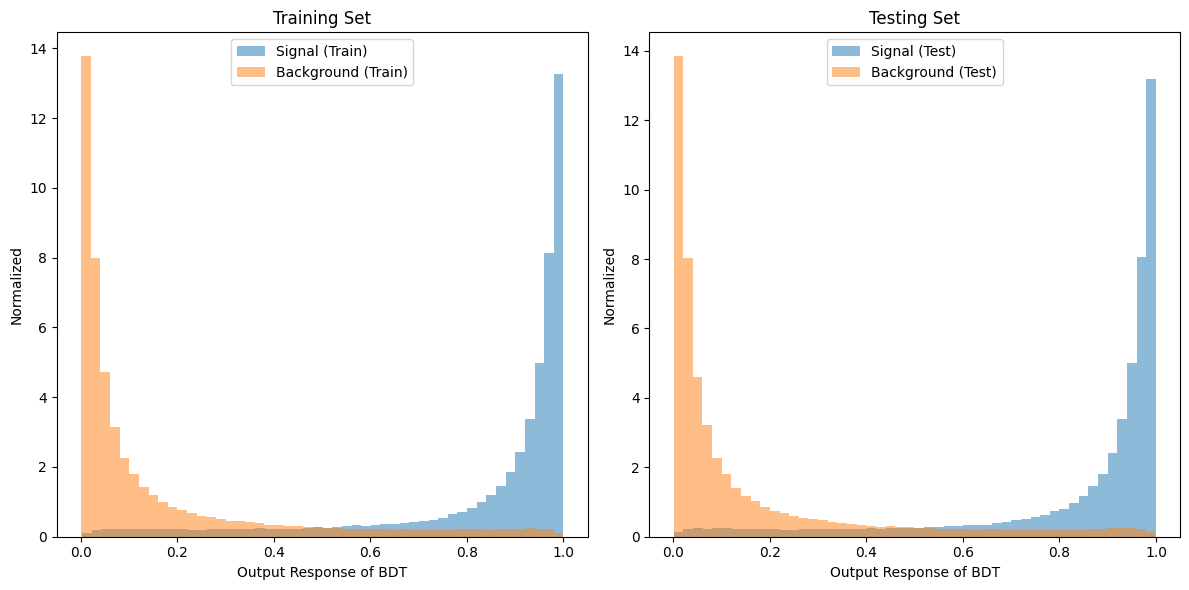

In [22]:
# Checking output responses for overfitting

train_signal_probs = bdt.predict_proba(X_train)[:, 1]
test_signal_probs = bdt.predict_proba(X_test)[:, 1]

plt.figure(figsize=(12, 6))

# Plot histograms for signal and background in training set
plt.subplot(1, 2, 1)
plt.hist(train_signal_probs[y_train == 1], bins=50, alpha=0.5, label='Signal (Train)', density = True)
plt.hist(train_signal_probs[y_train == 0], bins=50, alpha=0.5, label='Background (Train)', density = True)

counts_sig, edges_sig = np.histogram(test_signal_probs[y_test == 1], bins=50, density = True)
bin_centers_sig = (edges_sig[:-1] + edges_sig[1:]) / 2
sig_error = np.sqrt(counts_sig)

counts_bkg, edges_bkg = np.histogram(test_signal_probs[y_test == 0], bins=50, density = True)
bin_centers_bkg = (edges_bkg[:-1] + edges_bkg[1:]) / 2
bkg_error = np.sqrt(counts_bkg)

#plt.errorbar(bin_centers_sig, counts_sig, yerr = sig_error, ls = '',fmt='o',color='blue', label='Signal (Test)')
#plt.errorbar(bin_centers_bkg, counts_bkg, yerr = bkg_error, ls = '',fmt='o',color='red', label='Background (Test)')

plt.xlabel('Output Response of BDT')
plt.ylabel('Normalized')
plt.title('Training Set')
plt.legend(loc = 'upper center')

# Plot histograms for signal and background in testing set
plt.subplot(1, 2, 2)
plt.hist(test_signal_probs[y_test == 1], bins=50, alpha=0.5, label='Signal (Test)', density = True)
plt.hist(test_signal_probs[y_test == 0], bins=50, alpha=0.5, label='Background (Test)', density = True)
plt.xlabel('Output Response of BDT')
plt.ylabel('Normalized')
plt.title('Testing Set')
plt.legend(loc = 'upper center')

plt.tight_layout()
plt.show()

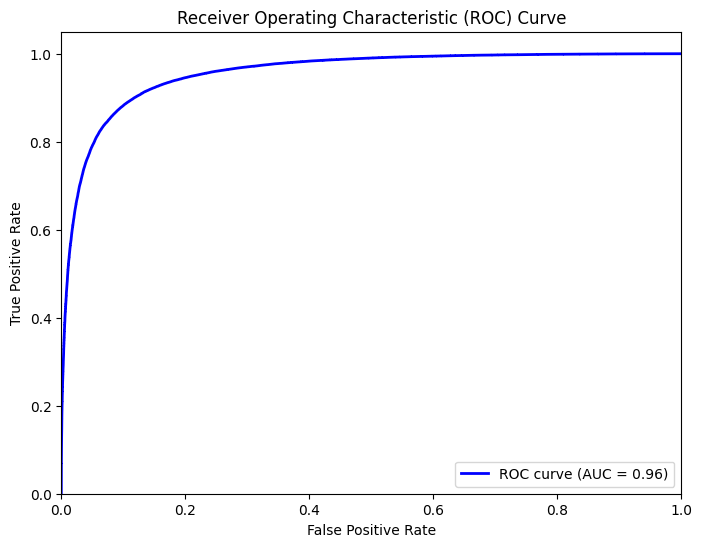

In [24]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_signal_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
y_pred = (test_signal_probs > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Calculate accuracy score
accuracy = np.mean(y_pred == y_test)

print("Area under the ROC curve (AUC): {:.2f}".format(roc_auc))
print("XGBoostClassifier Model Accuracy:", accuracy_score(y_test, y_pred)*100)

Area under the ROC curve (AUC): 0.96
XGBoostClassifier Model Accuracy: 89.13271240832556


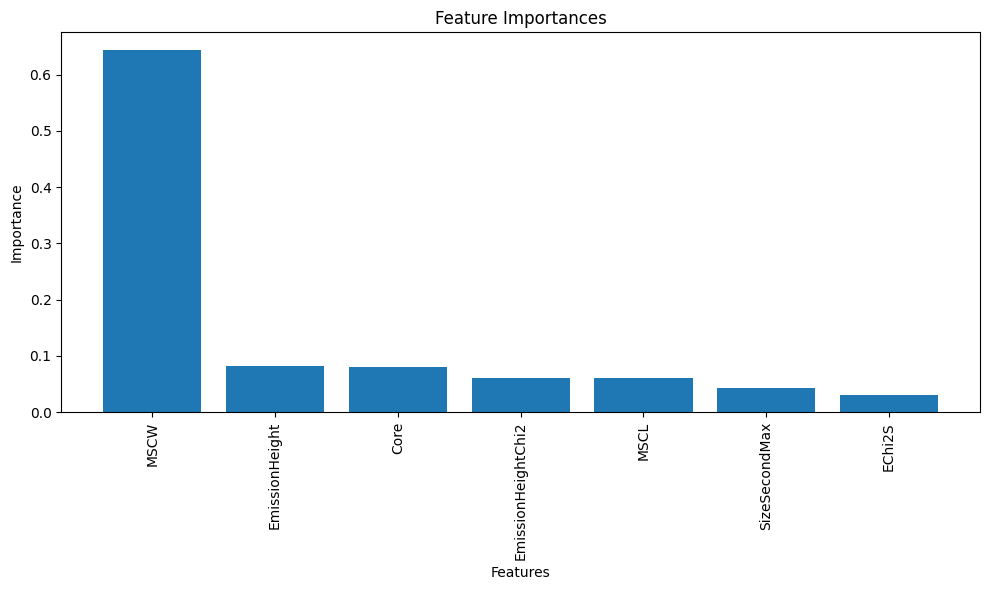

[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=500;, score=0.956 total time= 5.9min
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=500;, score=0.955 total time= 5.9min
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=1000;, score=0.955 total time=11.7min
[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=1000;, score=0.956 total time=10.0min
[CV 5/5] END learning_rate=0.3, max_depth=9, n_estimators=1000;, score=0.951 total time=35.2min
[CV 4/5] END learning_rate=0.3, max_depth=9, n_estimators=1000;, score=0.950 total time=35.3min
[CV 2/5] END learning_rate=0.3, max_depth=9, n_estimators=1000;, score=0.950 total time=35.3min
[CV 1/5] END learning_rate=0.3, max_depth=9, n_estimators=1000;, score=0.951 total time=35.3min
[CV 3/5] END learning_rate=0.3, max_depth=9, n_estimators=1000;, score=0.950 total time=35.4min


In [28]:
# Get feature importances
feature_importances = bdt.best_estimator_.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': col.columns,
    'Importance': feature_importances
})

# Sort the features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [21]:
import pickle
filename = 'BDT_train.sav'
pickle.dump(bdt, open(filename, 'wb'))